In [1]:
from qiskit import QuantumCircuit, Aer, transpile, assemble, execute
from qiskit.visualization import plot_histogram
import numpy as np
import random

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

import pandas as pd
import sys
sys.path.append("../")
from qmg.utils import MoleculeQuantumStateGenerator

num_heavy_atom = 2
data_path = f"../dataset/chemical_space/effective_{num_heavy_atom}.csv"
data_generator = MoleculeQuantumStateGenerator(heavy_atom_size=num_heavy_atom, ncpus=16)
data = pd.read_csv(data_path)
data.head()

,decimal_index,smiles
0,4,C
1,8,O
2,12,N
3,16,C
4,21,CC


In [2]:
from typing import List, Union
import numpy as np

def controlled_ry(qc, control, target, digit):
    # Apply H to target if control is |1>
    qc.cry(np.pi*digit, control,target)
    # qc.ry(-np.pi/2 * digit, target)
    # qc.cx(control, target)
    # qc.ry(np.pi/2 * digit, target)

def build_two_atoms(qc, weight_vector: Union[List[float], np.ndarray]):
    assert len(weight_vector) == 8
    qc.ry(np.pi * weight_vector[0], 0)
    qc.x(1)
    qc.ry(np.pi * weight_vector[2], 2)
    qc.ry(np.pi * weight_vector[4], 3)
    qc.cx(0, 1)
    controlled_ry(qc, 1, 2, weight_vector[3])
    qc.cx(2, 3)
    controlled_ry(qc, 0, 1, weight_vector[1])
    qc.cx(1, 2)
    controlled_ry(qc, 2, 3, weight_vector[5])

    qc.x(2)
    qc.x(3)
    qc.x(4)
    qc.ccx(2,3,4) # store the |00> state in ancilla qubit (fourth qubit).
    qc.x(2)
    qc.x(3)

    qc.cx(4, 5)
    qc.cx(5, 6)
    controlled_ry(qc, 4, 5, weight_vector[6])
    qc.cx(5, 6)
    controlled_ry(qc, 5, 6, weight_vector[7])

def build_bond_type_circuit(qc, heavy_atom_number: int, fixed_weight_vector: Union[List[float], np.ndarray],
                            flexible_weight_vector: Union[List[float], np.ndarray]):
    num_target_qubit = (heavy_atom_number - 1) * 2
    # assert np.abs(np.sum(weight_vector) - 1) < 1e-5
    assert len(fixed_weight_vector)*2 == num_target_qubit == len(flexible_weight_vector)
    # ancilla qubit indicating the existence of heavy_atom_number
    ancilla_qubit_index = 2*heavy_atom_number + (heavy_atom_number-1)**2 - 1
    for i in range(2*(heavy_atom_number-1)):
        qc.cx(ancilla_qubit_index+i, ancilla_qubit_index+i+1)
    for i in range((heavy_atom_number-1)):
        controlled_ry(qc, ancilla_qubit_index+num_target_qubit-2*i-1, ancilla_qubit_index+num_target_qubit-2*i, 1-fixed_weight_vector[-1-i])
        qc.cx(ancilla_qubit_index+num_target_qubit-2*i-2, ancilla_qubit_index+num_target_qubit-2*i-1)
        controlled_ry(qc, ancilla_qubit_index+num_target_qubit-2*i, ancilla_qubit_index+num_target_qubit-2*i-1, flexible_weight_vector[-2-2*i])
        controlled_ry(qc, ancilla_qubit_index+num_target_qubit-2*i-1, ancilla_qubit_index+num_target_qubit-2*i, flexible_weight_vector[-1-2*i])
        # controlled_ry(qc, ancilla_qubit_index+2*i+1, ancilla_qubit_index+2*i+2, 1-fixed_weight_vector[i])
        # controlled_ry(qc, ancilla_qubit_index+2*i+2, ancilla_qubit_index+2*i+1, flexible_weight_vector[2*i])
        # controlled_ry(qc, ancilla_qubit_index+2*i+1, ancilla_qubit_index+2*i+2, flexible_weight_vector[2*i+1])


def build_atom_type_circuit(qc, heavy_atom_number: int, weight_vector: Union[List[float], np.ndarray]):
    assert len(weight_vector) == 3
    ancilla_qubit_index = 2*(heavy_atom_number-1) + (heavy_atom_number-2)**2 - 1
    qubit_1_index = ancilla_qubit_index + 2*(heavy_atom_number - 2) + 1
    qubit_2_index = qubit_1_index + 1
    qc.cx(ancilla_qubit_index, qubit_1_index)
    controlled_ry(qc, qubit_1_index, qubit_2_index, weight_vector[1])
    controlled_ry(qc, ancilla_qubit_index, qubit_1_index, weight_vector[0])
    qc.cx(qubit_2_index, qubit_1_index)
    controlled_ry(qc, qubit_1_index, qubit_2_index, weight_vector[2])
    
    qc.x(qubit_1_index)
    qc.x(qubit_2_index)
    qc.x(qubit_2_index+1)
    qc.ccx(qubit_1_index,qubit_2_index,qubit_2_index+1) # store the |00> state in ancilla qubit.
    qc.x(qubit_1_index)
    qc.x(qubit_2_index)

    
num_heavy_atom = 3
num_qubits = num_heavy_atom*(num_heavy_atom+1)
num_ancilla_qubits = num_heavy_atom - 1
qc = QuantumCircuit(num_qubits+num_ancilla_qubits, num_qubits)
build_two_atoms(qc, [0.7, 0.3, 0.6, 0.3, 0.2, 0.6, 0.6, 0.3])
# build_bond_type_circuit(qc, 2, [0.5, 0.5])
if num_heavy_atom - 2:
    for heavy_idx in range(3, num_heavy_atom+1):
        atom_type_weight_vector = [random.random() for _ in range(3)]
        bond_type_fixed_weight_vector = np.array([random.random() for _ in range((heavy_idx-1))])
        bond_type_fixed_weight_vector = bond_type_fixed_weight_vector / np.sum(bond_type_fixed_weight_vector)
        # bond_type_fixed_weight_vector = sorted(bond_type_fixed_weight_vector)
        # bond_type_fixed_weight_vector = bond_type_fixed_weight_vector / 2
        print(bond_type_fixed_weight_vector)

        bond_type_flexible_weight_vector = np.array([random.random() for _ in range((heavy_idx-1)*2)])
        build_atom_type_circuit(qc, heavy_idx, atom_type_weight_vector)
        build_bond_type_circuit(qc, heavy_idx, bond_type_fixed_weight_vector, bond_type_flexible_weight_vector)


effective_qubit_index = list(range(num_qubits+num_ancilla_qubits))
for j in range(2, num_heavy_atom+1):
    ancilla_qubit_number = 2*j + (j-1)**2 - 1
    effective_qubit_index.remove(ancilla_qubit_number)
print(effective_qubit_index)
qc.measure(effective_qubit_index, list(range(num_qubits)))

# 执行量子电路
simulator = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(qc, simulator)
qobj = assemble(compiled_circuit)
results = execute(qc, backend=simulator, shots=4096*8).result()
counts = results.get_counts(qc)

data_generator = MoleculeQuantumStateGenerator(heavy_atom_size=num_heavy_atom, ncpus=16)
print(len(counts))
# plot_histogram(counts)
# qc.draw(output="mpl")

[0.451959070435309, 0.5480409295646909]
[0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13]


/tmp/ipykernel_3323084/3088310436.py:103: DeprecationWarning: The 'qiskit.Aer' entry point is deprecated and will be removed in Qiskit 1.0. You should use 'qiskit_aer.Aer' directly instead.
  simulator = Aer.get_backend('qasm_simulator')
/tmp/ipykernel_3323084/3088310436.py:106: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  results = execute(qc, backend=simulator, shots=4096*8).result()


777


/beegfs/home/lungyi45/.conda/envs/qmg/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


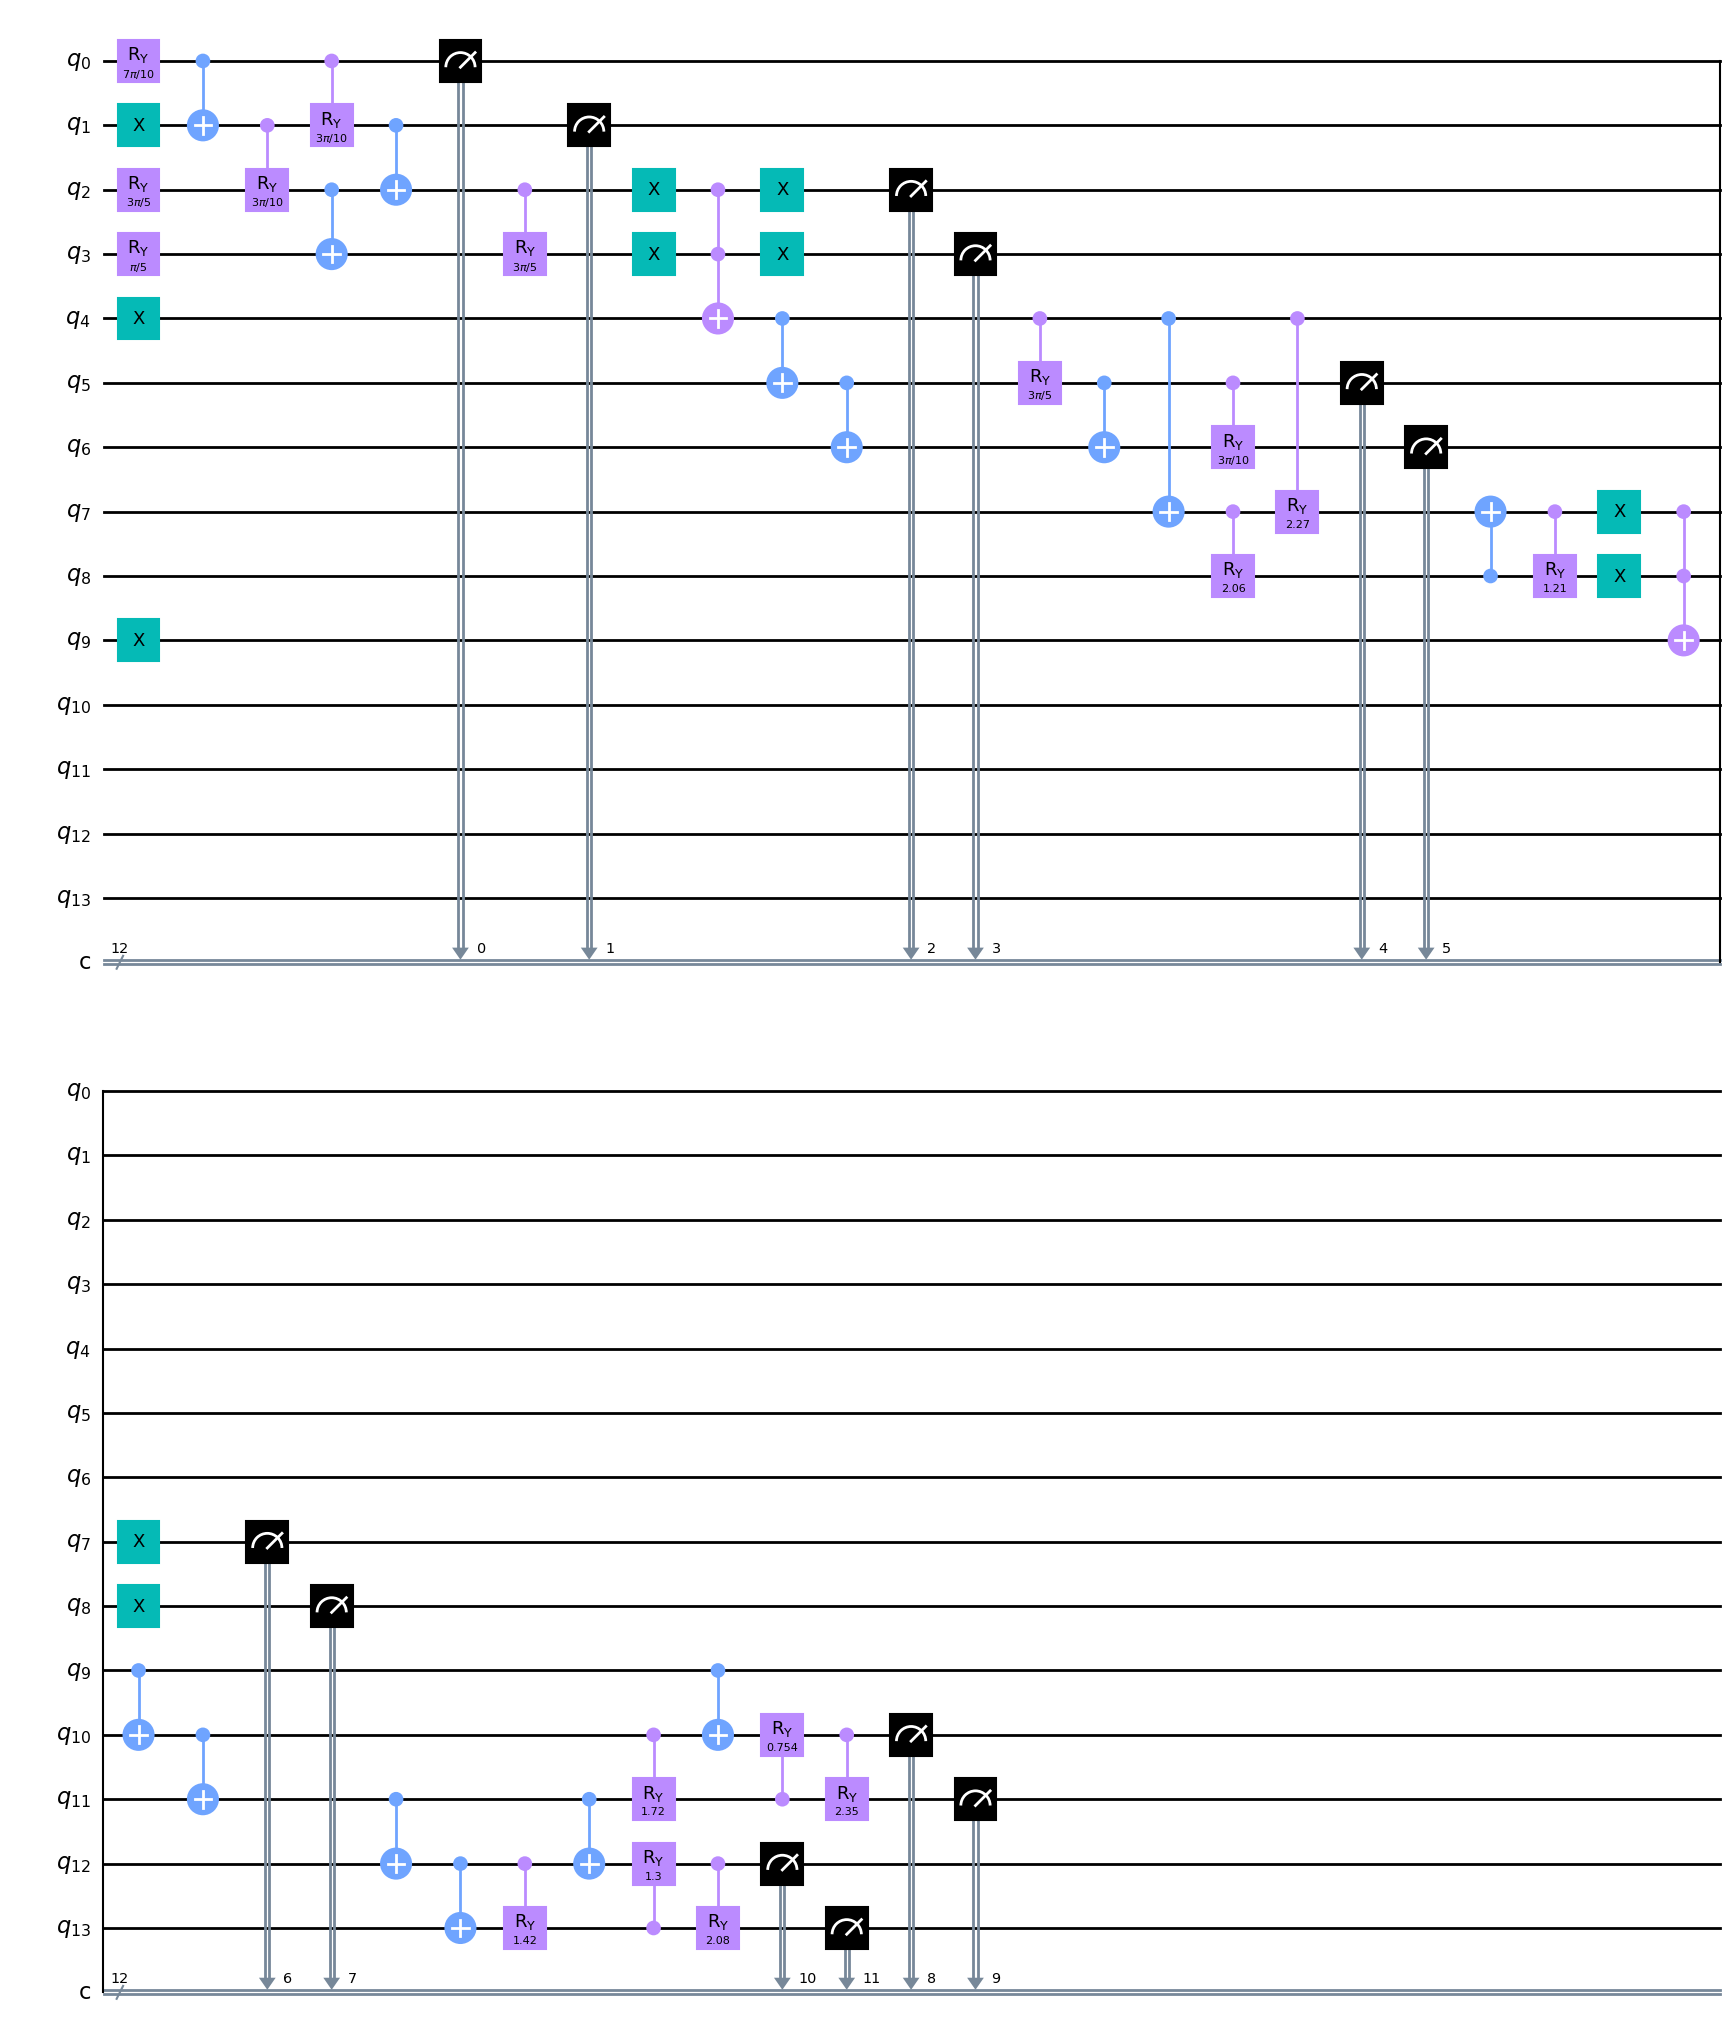

In [3]:
qc.draw(output="mpl")

In [4]:
data_generator = MoleculeQuantumStateGenerator(heavy_atom_size=num_heavy_atom, ncpus=16, sanitize_method="soft")
smiles_list = []
for key, value in counts.items():
    print(key[::-1], data_generator.post_process_quantum_state(key), value)
    smiles = data_generator.QuantumStateToSmiles(data_generator.post_process_quantum_state(key))
    print(smiles)
    smiles_list.append(smiles)
print(set(smiles_list))

100110010111 100101100111 1
None
101001011100 101001011100 1
C#[O+2]O
110110011100 110101101100 1
C#[N+2]=C
111010110111 111011100111 1
N1=[O+3]#[N+]1
011001011000 011001011000 1
C=CO
111010010111 111001100111 1
C1#[O+3]=N1
111111101101 111110111101 1
[N+]1#[N+3]#[O+2]1
011001010101 011001010101 1
C1CO1
100111110010 100111110010 1
None
111110101001 111110101001 2
N1=[N+]=[O+]1
110111101101 110110111101 1
C1#[N+3]#[O+2]1
101110101111 101110101111 1
[N+]1#[O+4]#[O+2]1
011110100011 011110100011 1
C=[N+2]#[O+]
101011011011 101001111011 1
None
110110101110 110110101110 1
C1=[N+2]#[O+3]=1
011101110110 011111010110 1
C1N=N1
100110010011 100101100011 1
None
111110111001 111111101001 1
N1=[N+]=N1
101110101110 101110101110 2
[N+]1=[O+3]#[O+3]=1
111010010100 111001100100 1
CN=O
101001011101 101001011101 1
C1#[O+2]O1
110101011001 110101011001 1
C1=NC1
111101111100 111111011100 2
N#[N+]N
111101011100 111101011100 1
C#[N+]N
100101011000 100101011000 1
C=[O+]C
111011000000 111000110000 1
N#[O+]
10101

In [7]:
data_generator = MoleculeQuantumStateGenerator(heavy_atom_size=num_heavy_atom, ncpus=16, sanitize_method="None")
data_generator.QuantumStateToSmiles("100110100111")

'C1#OO=1'

In [10]:
print(data_generator.QuantumStateToSmiles("101011"))

None


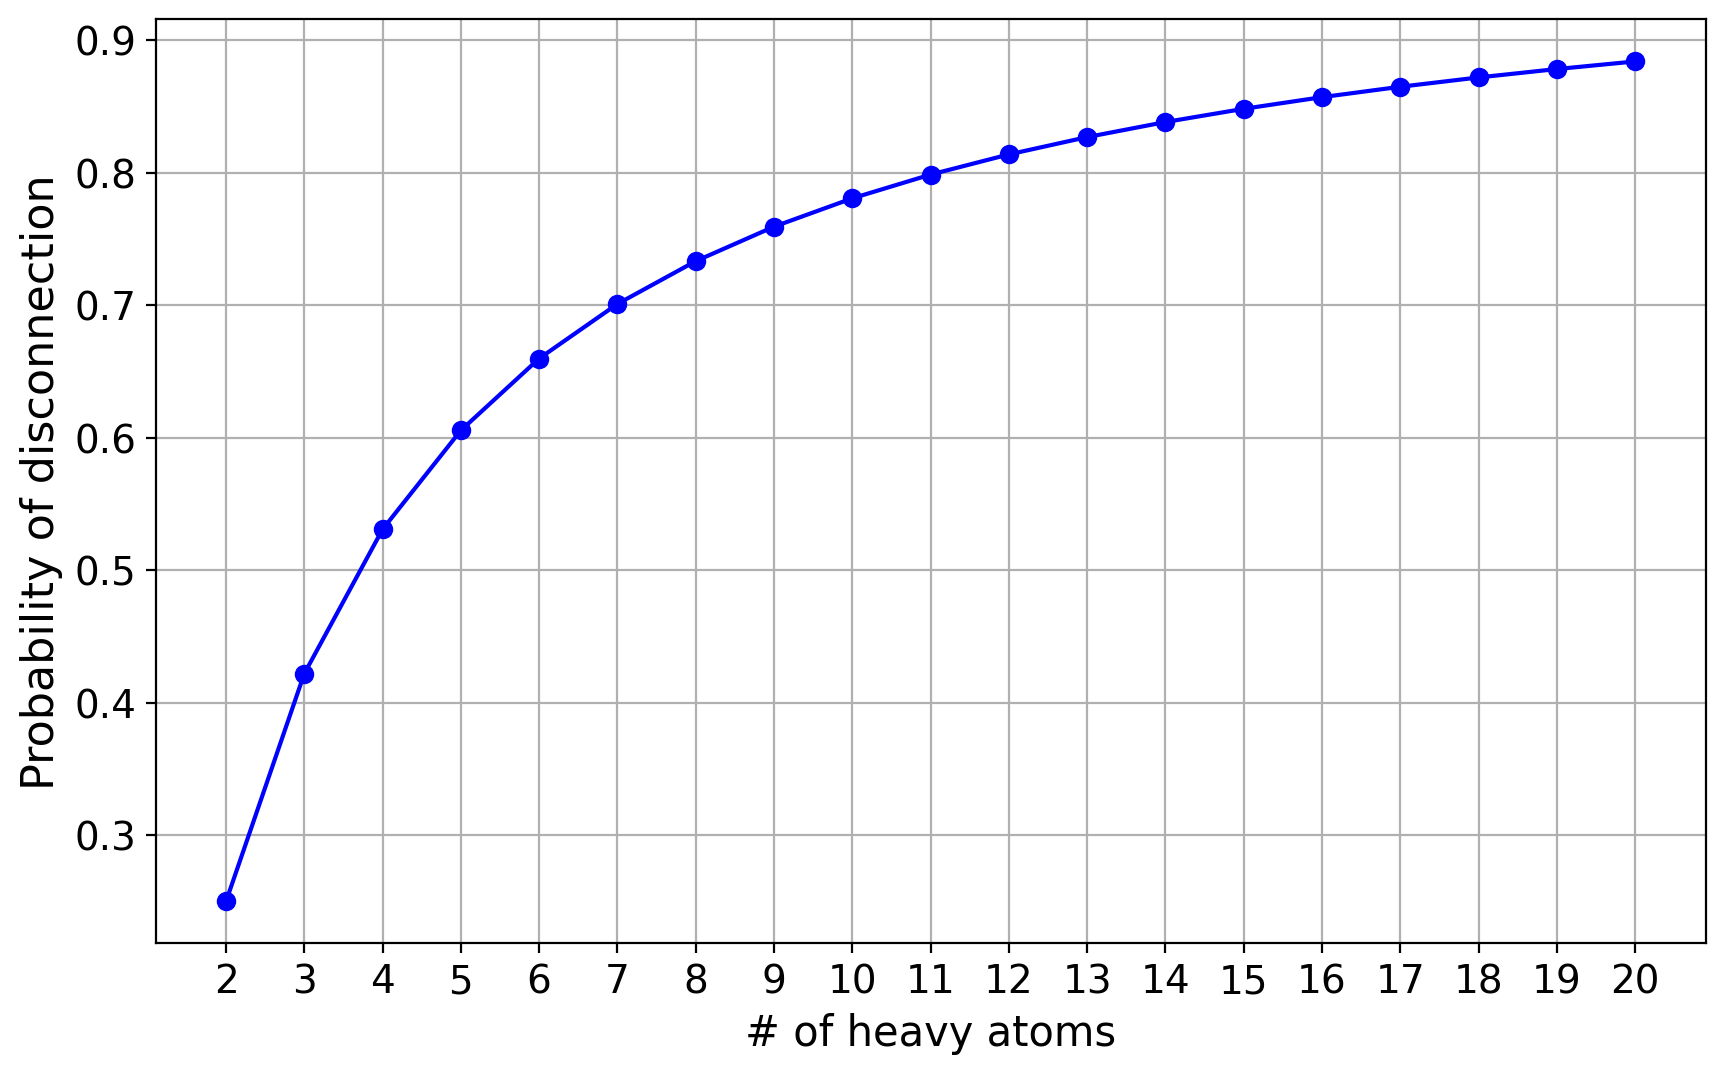

In [24]:
import matplotlib.pyplot as plt

def plot_line_chart(x, y, title='Line Chart', xlabel='X-axis', ylabel='Y-axis'):
    plt.figure(figsize=(10, 6), dpi=200)
    plt.plot(x, y, marker='o', linestyle='-', color='b', label='Line')
    plt.title(title)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=16)
    plt.xticks(x)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True)
    # plt.legend()
    plt.show()

# Example usage
x = np.array(list(range(2, 21)))
y = np.array([np.cos(np.pi/2/n)**(2*n) for n in x])

plot_line_chart(x, y, title=None, xlabel='# of heavy atoms', ylabel='Probability of disconnection')


In [12]:
np.cos(np.pi/4)**4

0.25000000000000006

In [30]:
np.cos(np.pi/2/np.sqrt(2))**(2*1)

0.19715006646059333